                                Extension to AutoStan/fpfStan
    
                Purpose : To run linear and logistic regression in Stan via PyStan
            
                                        10-March-2021

Detect and Fix Multi-collindearity

- Get a data set
- Get the user to provide the responsive variable
- Clean the data to fix null and missing values 
- Compute a correlation matrix
- Provide  a visualization of highly correlated variables
- When two variables are highly correlated drop the one that contributes less to the model89


The above will be achieved by following functions :

    - Visualisations
    - missing_values
    - cal_corr
    - train_split
    - remove_correlated_features

the objective is to produce a dataset without Multicollinearity

In [1]:
#import the following packages
import json    # to load config file
from pandas import DataFrame
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import display

In [2]:
#this class helps to bold header text in the report
class color:
   BOLD = '\033[1m'
   END = '\033[0m'

In [3]:
# purpose -: to display correlation heat map and correlation matrix
# input   -: dataset
# output  -: visualization

def visualizations(dataset):
    #correlation
    fig = plt.figure(figsize=(10,8))
    fig.suptitle('\nCorrelation Analysis', fontsize = 20) 
    sns.heatmap(dataset.corr(), annot = True, cmap="YlGnBu")   #heat map plotter
    plt.show()
    print('\n'*2)
    print('-'*120)
    print('\n')
    print(color.BOLD + 'Correlation Matrix'+ color.END)
    display(dataset.corr()) # display correlation n*n matrix

In [4]:
# purpose -: resolves missing values from the dataset and isolates categorical featurs
# input   -: dataset and strategy to resolve missing values
# output  -: dataset without missing values and categorical features


def missing_values(dataset,missing_strategy='mean'): # default strategy to resolve missing values is using column mean
    numerics = ['int16', 'int32','int64', 'float16', 'float32', 'float64'] 
    numerical_features = list(dataset.select_dtypes(include=numerics).columns) # select all columns that are numeric type
    dataset=dataset[numerical_features] # new dataset which excludes categorical data
    result=dataset.isnull().sum()
    missing=[]   # list to save variables with missing values
    for i in range(len(result)):
        if(result[i]>0):
            missing.append(i)  #save missing values
    if(len(missing)==0):
        print('no missing values')  # message if there are no variables with missing variables
        
    else:
        for i in missing:
            print(result.index[i] + " had : {} missing values : Resolved".format(result[i]))
            
            selection = missing_strategy
            if(selection=='zero'):
                dataset=dataset.fillna(0)   # fill in zeros to missing values 
            else:
                dataset=dataset.apply(lambda x: x.fillna(x.mean()),axis=0) # fill in missing value using mean in column
            
    return dataset
    

In [5]:
# purpose -: calculates correlation and records all highly correlated pairs 
# input   -: dataset with only numerical features and correlation threshold
# output  -: correlation matrix


def cal_corr(dataset,target,threshold=0.8): # default correlation matrix is 0.8

    dataset=dataset.drop(columns=[target]) 
    corr_matrix = dataset.corr()     # Build a Dataframe of highly correlated variables
    # Take absolute values of highly correlated coefficients
    corr_matrix = corr_matrix.abs().unstack()   #unstack the n*n matrix to 3*all variable possible combinations of 2s
    corr_matrix = corr_matrix.sort_values(ascending=False) # sort the table in descending order
    # Take only features with correlation above threshold
    corr_matrix = corr_matrix[corr_matrix >= threshold] 
    corr_matrix = corr_matrix[corr_matrix < 1]
    corr_matrix = pd.DataFrame(corr_matrix).reset_index()
    corr_matrix.columns = ['feature1', 'feature2', 'Correlation'] #table with correlated features and correlation coefficient
    
    return corr_matrix

In [6]:
# purpose -: data spliting and dropping a column.
# input   -: dataset, and column to be in the dataset
# output  -: split dataset

def train_split(dataset,to_be_dropped,target):

    dataset=dataset.drop(columns=[to_be_dropped])
    x_train,x_test,y_train,y_test=train_test_split(dataset.drop(columns=[target]),dataset[target],train_size=0.7,random_state=100)

    return x_train,x_test,y_train,y_test
    

In [7]:
# purpose -: remove correlated features 
# input   -: dataset, target and treshold
# output  -: dataset without features with high correlation


def remove_correlated_features(dataset,target,threshold):
    iterations=1 # initialize loop
    corr_matrix=cal_corr(dataset,target,threshold) #call cal_corr function to get a table of highly correlated features
    print(color.BOLD +'\nTable of highly correlated features'+ color.END)
    print('\n')
    display(corr_matrix)
    
    
    print('_'*120)
    print('\n')
    print(color.BOLD +'Removing highly correlated features'+ color.END)
    print('\n')
    
    
    
    #the function has a loop the loop performs the following 
    #-from the table of highly correlated features, the table takes the top 2 features in each loop
    #-the first feature is removed from the dataset, the dataset is slipt by the train_slipt function
    #-the train set is fit on the model, and an R2 is saved
    #-the second feature is also done the same as the first
    #-the feature which cotributes a high R2 score between the e features is eliminated
    #-any row with the eliminated feature is removed the table of features with high correlation
    #-the process is repeated until the table is empty
    min_col = []
    max_col = []
    while(iterations==1):
        correlated_col=[]   #save the curent correlated features
        res=[]                 #stores R2
        rem_col = []

        try:
            for i in range(2):  #collect the 2 correlated features
                 correlated_col.append(corr_matrix.iloc[0][i])    # take the top correlated features from the table


            for i in range(2): #iterate the 2 correlated features
                col=correlated_col[i]  
                try :    
                    x_train,x_test,y_train,y_test=train_split(dataset,col,target) # remove the features from the deataset one by one
                    lm = LinearRegression() 
                    lm.fit(x_train,y_train)  #fit the model 

                    y_train_pred = lm.predict(x_train)
                    y_test_pred = lm.predict(x_test)

                    

                    res.append(r2_score(y_test,y_test_pred)) # evaluates R2 and saves the R2 score with the removed feature



                except TypeError:
                    print('Cannot drop target')       
           
            
            min_col.append([correlated_col[res.index(min(res))],res[res.index(min(res))]])
            max_col.append([correlated_col[res.index(max(res))],res[res.index(max(res))]])

            
            dataset=dataset.drop(columns=[correlated_col[res.index(min(res))]]) #eliminates the feature which contributes less to the model from the dataset using R2 score
            corr_matrix.drop(corr_matrix.index[(corr_matrix["feature1"] == correlated_col[res.index(min(res))])],axis=0,inplace=True) # eliminate feature from table of highly correlated features
            corr_matrix.drop(corr_matrix.index[(corr_matrix["feature2"] == correlated_col[res.index(min(res))])],axis=0,inplace=True)



        except IndexError:
            
            iterations=0
    
            
    print('Selection Criterion : R Squared - higher is desirable \n-Features in the Keep_Features column will be kept in the dataset \n-Features in the Remove_Features will be removed from the dataset')
    
    feat_keep = pd.DataFrame(min_col, columns=['Removed_Features', 'R2 Score_'])
    delete_keep = pd.DataFrame(max_col,columns=['Keep_Features', 'R2 Score'])
    
    df= feat_keep.merge(delete_keep,left_index=True,right_index=True)
    
    display(df)
            
    return dataset

In [8]:
# purpose -: read the config file, call other other function to process the data
# input   -: none
# output  -: dataset witout Multicollinearity

def load_and_process():
    
    with open('config.json') as f:
        data = json.load(f)
    
    path = data['path']
    #loading dataset
    try:
        dataset = pd.read_csv(path)

    except FileNotFoundError:
         print('File not found please enter again \n') # error message if path is not found

    #loading target
    cols=dataset.columns          #collect all column names
    
    
    target = data['target_variable']
    
    if(target in(cols)):      #check if target column is a column in the dataset

        target=data['target_variable']

    else:
         print('\n Target column found try again') # error message if target is not found

    #loading threshold
    try : 
        threshold = float(data['correlation_threshold']) # check if value is numerical
    except ValueError:
         print('Enter again threshold not numerical')
    
    missing=data['missing_value_strategy']
    
    if(missing=='zero' or missing=='mean'):
        missing=data['missing_value_strategy']
    else:
        print('-----------------------------------------------')
        print('Missing value strategy is not valid \nSelect between zero or mean \ndefault mean will be used')
        print('-----------------------------------------------')
    
    print('The following parameters have been loaded from the config file\n')  #shows the user the parameters in the config file
    print('Dataset file path  :',path)
    print('Target variable :',target)
    print('Correlation Threshold :',threshold)
    print('Missing value Strategy :',missing)
    print('-'*50)
    
    dataset=missing_values(dataset,missing)  #processes the missing values
    dataset_target=dataset[target]
    print('_'*120)
    visualizations(dataset) # displays visualizations (heatmape for correlation of features and the correlation matrix)
    print('\n')
    print('_'*120)
    
    
    dataset=remove_correlated_features(dataset,target,threshold)
    
    print('\n')
    
    dataset.to_csv('nc_'+path)
    print('Dataset without Multicollinearity will be saved in : nc_{}'.format(path))
    print('_'*120)
    
    
    
    return dataset,target

The following parameters have been loaded from the config file

Dataset file path  : Credit-Scoring-Clean.csv
Target variable : CreditStatus
Correlation Threshold : 0.8
Missing value Strategy : mean
--------------------------------------------------
no missing values
________________________________________________________________________________________________________________________


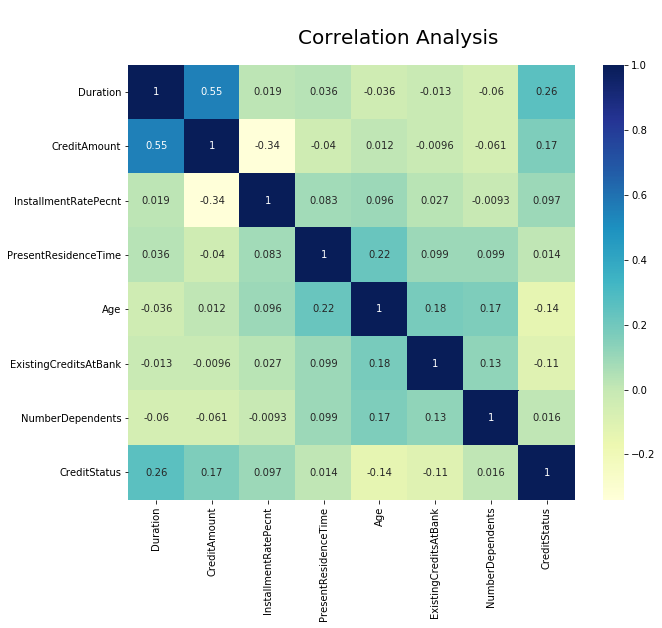




------------------------------------------------------------------------------------------------------------------------


Correlation Matrix


,Duration,CreditAmount,InstallmentRatePecnt,PresentResidenceTime,Age,ExistingCreditsAtBank,NumberDependents,CreditStatus
Duration,1.000000,0.554653,0.019456,0.036132,-0.036233,-0.013222,-0.059799,0.257448
CreditAmount,0.554653,1.000000,-0.339137,-0.040389,0.011901,-0.009640,-0.061291,0.165472
InstallmentRatePecnt,0.019456,-0.339137,1.000000,0.083295,0.095750,0.027304,-0.009261,0.097442
PresentResidenceTime,0.036132,-0.040389,0.083295,1.000000,0.222569,0.099359,0.099288,0.014401
Age,-0.036233,0.011901,0.095750,0.222569,1.000000,0.181280,0.166937,-0.140142
ExistingCreditsAtBank,-0.013222,-0.009640,0.027304,0.099359,0.181280,1.000000,0.125038,-0.108153
NumberDependents,-0.059799,-0.061291,-0.009261,0.099288,0.166937,0.125038,1.000000,0.015724
CreditStatus,0.257448,0.165472,0.097442,0.014401,-0.140142,-0.108153,0.015724,1.000000




________________________________________________________________________________________________________________________

Table of highly correlated features




,feature1,feature2,Correlation


________________________________________________________________________________________________________________________


Removing highly correlated features


Selection Criterion : R Squared - higher is desirable 
-Features in the Keep_Features column will be kept in the dataset 
-Features in the Remove_Features will be removed from the dataset


,Removed_Features,R2 Score_,Keep_Features,R2 Score




Dataset without Multicollinearity will be saved in : nc_Credit-Scoring-Clean.csv
________________________________________________________________________________________________________________________


In [9]:
dataset,target=load_and_process()

In [10]:
dataset

,Duration,CreditAmount,InstallmentRatePecnt,PresentResidenceTime,Age,ExistingCreditsAtBank,NumberDependents,CreditStatus
0,0.205882,0.161770,0.333333,0.333333,0.089286,0.000000,0.0,1
1,0.294118,0.058380,1.000000,0.666667,0.125000,0.000000,0.0,0
2,0.205882,0.069055,1.000000,0.333333,0.232143,0.000000,0.0,0
3,0.647059,0.358094,0.666667,0.333333,0.214286,0.000000,0.0,1
4,0.029412,0.023825,0.333333,0.000000,0.178571,0.000000,0.0,0
...,...,...,...,...,...,...,...,...
945,0.341710,0.154877,1.000000,0.333333,0.191593,0.000000,0.0,1
946,0.175015,0.134978,1.000000,0.179146,0.717821,0.247931,0.0,1
947,0.173663,0.121347,1.000000,0.093443,0.222093,0.000000,0.0,1
948,0.060279,0.045761,1.000000,0.487520,0.068551,0.000000,0.0,1


# Basic Linear Regression with PyStan

Using the above dataset without multicollinearity, the data will be fitted on a Linear Regression Model in PyStan

In [11]:
import scipy
import pystan
from scipy.stats import mode
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report


In [12]:
labels=dataset['CreditStatus']
dataset_=dataset.drop(columns=['CreditStatus'])

In [13]:
#purpose : Fit a Bayesian logistic regression model
#input   : feature dataset and label dataset
#output  : fitted model

def fit(dataset, labels):
  """Fit a Bayesian logistic regression model using MCMC sampling.
   	Args:
		input_fn: lambda function that return training data as two numpy arrays (x, y).
		
	Returns:
		fit: Fitted Stan output.	
	"""
  X_train, X_test, y_train, y_test = train_test_split(dataset,labels, stratify=labels, test_size=0.25, random_state=42)

  linear = """
    /* Stan model code for logistic regression */
        data {
        int<lower=1> N; // number of training samples
        int<lower=0> K; // number of predictors - 1 (intercept)
        matrix[N, K] x; // matrix of predictors
        vector[N] y_obs; // observed/training mpg
        
        int<lower=1> N_new;
        matrix[N_new, K] x_new;
    }
    parameters {
        real alpha;
        vector[K] beta;
        real<lower=0> sigma;
        
        vector[N_new] y_new;
    }
    transformed parameters {
        vector[N] theta;
        theta = alpha + x * beta;
    }
    model {
        sigma ~ exponential(1);
        alpha ~ normal(0, 6);
        beta ~ multi_normal(rep_vector(0, K), diag_matrix(rep_vector(1, K)));
        y_obs ~ normal(theta, sigma);
        
        y_new ~ normal(alpha + x_new * beta, sigma); // prediction model
    }
    """
   

  linear_dat = {'N': X_train.shape[0],
            'N_new': X_test.shape[0],
            'K': X_train.shape[1],
            'y_obs': y_train.values.tolist(),
            'x': np.array(X_train),
            'x_new': np.array(X_test)}

  sm = pystan.StanModel(model_code=linear)
  fit = sm.sampling(data=linear_dat, iter=6000, chains=8)

  evaluate(fit,y_test)

  return fit


#purpose : Evaluate the performance of fitted model on unseen test data.
#input   : fitted model, y test data set
#output  : MSE score of fitted model	

def evaluate(fit,y_test):
    
    la = fit.extract(permuted=True)
    bay_test_mse = mean_squared_error(y_test, la['y_new'].mean(0))
    print('-'*120)
    print('\n')
    print(color.BOLD +'Evaluation'+ color.END)
    print('\n')
    print(color.BOLD +'Bayes Test MSE:'+ color.END, bay_test_mse)
    print('-'*120)
    print('\n')
    print(color.BOLD +'Chain mixing — Trace plots & Regression plot'+ color.END)
    print('\n')
    ax = az.plot_trace(fit, var_names=["alpha","beta","sigma"])

 

    dff = pd.DataFrame({'y_pred':la['y_new'].mean(0), 'y_obs':y_test})
    grid = sns.JointGrid(dff.y_pred, dff.y_obs, space=0, height=6, ratio=50,
                        xlim=(0,50), ylim=(0,50))
    grid.plot_joint(plt.scatter, color="b")
    x0, x1 = grid.ax_joint.get_xlim()
    y0, y1 = grid.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    grid.ax_joint.plot(lims, lims, ':k')
    plt.subplots_adjust(top=0.9)
    grid.fig.suptitle('\nRegression Plot : Bayes Test Predicted vs Observed',fontsize=20)


    plt.show()

    return 

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7b0f51f0f208852a405b188ae8ad1e68 NOW.


------------------------------------------------------------------------------------------------------------------------


Evaluation


Bayes Test MSE: 0.2204043104143533
------------------------------------------------------------------------------------------------------------------------


Chain mixing — Trace plots & Regression plot




INFO:numba.transforms:finding looplift candidates


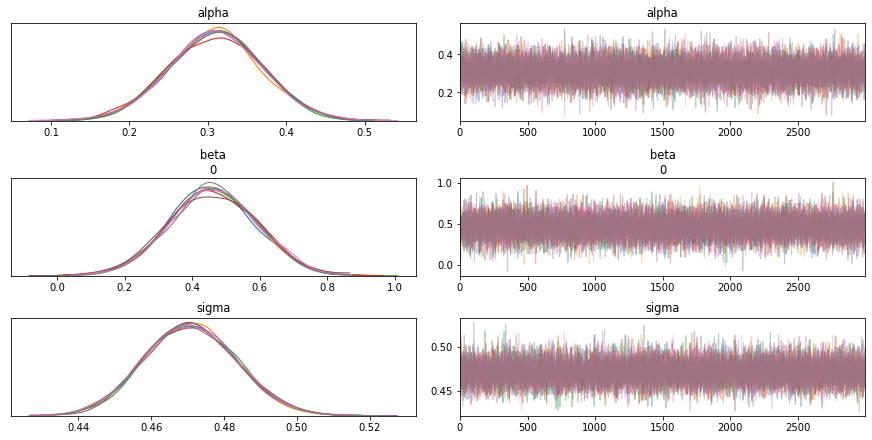

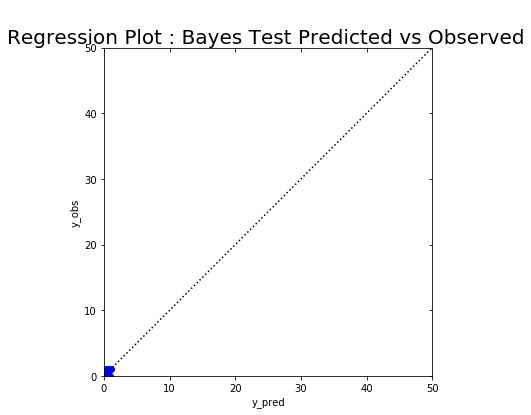

In [14]:
fit_model=fit(dataset_, labels)

# Logistic Regression with PyStan

In [15]:
#purpose : evaluate model performance
#input   :  true labels for a dataset, encodeed labels and dictionary for label encordings
#output  : classification report 

def evaluation(true_label,preds,encoder,encoder_dict):
  report=classification_report(encoder.transform(true_label), preds[:,0], output_dict=True)
  df_classification_report = pd.DataFrame(report).transpose()
  display(df_classification_report)
  plot_confusion_matrix(encoder.transform(true_label), preds[:,0],
  classes = np.asarray(list(encoder_dict.keys())))

In [16]:
#purpose :  This function prints and plots the confusion matrix.
#input   :  true and predicted labels for a dataset
#output  :  confusion matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):


    title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    return ax

In [17]:
#purpose : Function to load the categorical labels and convert them to integer labels
#input   : The values of the categorical labels
#output  :  The encoder to transform the categorical variables to integer labels fit on the data set
def encode_y(y):

    encoder = LabelEncoder()
    encoded_y = encoder.fit_transform(y)
    keys = encoder.classes_
    values = encoder.transform(encoder.classes_)
    values = [int(v) for v in values]
    dictionary = dict(zip(keys, values))

    return (encoder, dictionary)

In [18]:
#purpose :  Model predictions
#input   :  fit model, X_train dataset, X_test dataset
#output  :  predictions for train set and test set

def predict(fit_samp,X_train,X_test):
  X_np_train = X_train.to_numpy()
  X_np_test = X_test.to_numpy()
  preds_train = np.empty([X_np_train.shape[0], fit_samp['beta'].shape[0]])
  preds_test = np.empty([X_np_test.shape[0], fit_samp['beta'].shape[0]])
  for i in range(fit_samp['beta'].shape[0]):
      # Train
      scipy.special.softmax(X_np_train.dot(fit_samp['beta'][i, :]), axis=1)
      preds_train[:, i] = np.argmax(scipy.special.softmax(X_np_train.dot(fit_samp['beta'][0, :]), axis=1),
                                    axis=1)
      # Test
      scipy.special.softmax(X_np_test.dot(fit_samp['beta'][i, :]), axis=1)
      preds_test[:, i] = np.argmax(scipy.special.softmax(X_np_test.dot(fit_samp['beta'][0, :]), axis=1),
                                    axis=1)

  # Get consensus predictions from all samples
  preds_train = mode(preds_train, axis=1)[0]
  preds_test = mode(preds_test, axis=1)[0]

  return preds_train,preds_test

In [19]:
#purpose : fit logistic regression model
#input   : X-feature dataset, y - label dataset
#output  : fitted model
def fit_reg(X,y):
  logistic_ = """
    data {
          int N; //the number of training observations
          int N2; //the number of test observations
          int D; //the number of features
          int K; //the number of classes
          int y[N]; //the response
          matrix[N,D] x; //the model matrix
          matrix[N2,D] x_new; //the matrix for the predicted values
        }
        parameters {
          matrix[D,K] beta; //the regression parameters
        }

        model {
          matrix[N, K] x_beta = x * beta;
          to_vector(beta) ~ normal(0, 1);

          for (n in 1:N)
            y[n] ~ categorical_logit(x_beta[n]');

        }
          """

  X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.25, random_state=42)
  encoder, encoder_dict = encode_y(y)

  data = {
  'N': X_train.shape[0],
  'N2': X_test.shape[0],
  'D': X_train.shape[1],
  'K': len(np.unique(y_train)),
  'y': encoder.transform(y_train) + 1,
  'x': X_train,
  'x_new': X_test,
  }

  model = pystan.StanModel(model_code=logistic_)
  fit = model.sampling(data=data,
                        chains=1,
                        seed=5
  )

  fit_samp = fit.extract(permuted=True)

  preds_train,preds_test=predict(fit_samp,X_train,X_test)
  print('-'*120)
  print('\n'*2)
  print(color.BOLD +'Evaluation for train set'+ color.END)
  print('\n'*1)

  evaluation(y_train,preds_train,encoder,encoder_dict)

  print('-'*120)
  print('\n')
  print(color.BOLD +'Evaluation for test set'+ color.END)
  print('\n')
  evaluation(y_test,preds_test,encoder,encoder_dict)
  print('\n')
  print('-'*120)
  print('\n')
  print(color.BOLD +'Confusion Matrics'+ color.END)
  print('\n')
  print('N.B confusion Matrics for Train and Test set respectively')
  print('\n')


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c5e73ceec5e8a6af3bbb0316967c56e0 NOW.


------------------------------------------------------------------------------------------------------------------------



Evaluation for train set




,precision,recall,f1-score,support
0,0.668067,0.498433,0.570916,319.000000
1,0.662447,0.798982,0.724337,393.000000
accuracy,0.664326,0.664326,0.664326,0.664326
macro avg,0.665257,0.648707,0.647626,712.000000
weighted avg,0.664965,0.664326,0.655599,712.000000


------------------------------------------------------------------------------------------------------------------------


Evaluation for test set




,precision,recall,f1-score,support
0,0.622951,0.358491,0.455090,106.000000
1,0.615819,0.825758,0.705502,132.000000
accuracy,0.617647,0.617647,0.617647,0.617647
macro avg,0.619385,0.592124,0.580296,238.000000
weighted avg,0.618995,0.617647,0.593974,238.000000




------------------------------------------------------------------------------------------------------------------------


Confusion Matrics


N.B confusion Matrics for Train and Test set respectively




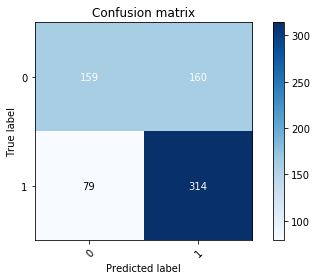

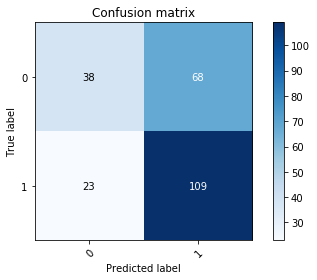

In [20]:
fit=fit_reg(dataset_,labels)
